In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("load.csv")
df = df.rename(columns={"Selecione Tipo de CE Simp 4":'load',"Day of Data Escala de Tempo 1 CE Simp 4":"date"})
df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y', errors='coerce')
df = df[df['date'] > pd.Timestamp("2020-12-31")]
df.index = df['date']
df = df.drop(['Subsistema','Data Escala de Tempo 1 CE Simp 4','Período Exibido CE Simp 4'],axis=1)

In [3]:
'''This step uses feature engineering to extract some good features for the 
 ARIMA model and the classical ones that will be developed in this project'''

df['day_of_week'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Sine/Cosine encoding for month seasonality
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Lag features
df['load_lag_1'] = df['load'].shift(1)
df['load_lag_7'] = df['load'].shift(7)
df['load_lag_30'] = df['load'].shift(30)

# Moving average
df['load_7ma'] = df['load'].shift(1).rolling(window=7).mean()

# Daily load change
df['load_change'] = df['load'] - df['load'].shift(1)

# Example: Adding holidays (replace with your country’s calendar)
brazil_holidays = ['2024-01-01', '2024-02-12', '2024-02-13', '2024-04-21', '2024-12-25']
df['is_holiday'] = df['date'].dt.strftime('%Y-%m-%d').isin(brazil_holidays).astype(int)

# Drop NA rows caused by shifting
df = df.dropna()
# df = df.drop('date',axis=1)

df.head()


,date,load,day_of_week,month,day_of_month,is_weekend,month_sin,month_cos,load_lag_1,load_lag_7,load_lag_30,load_7ma,load_change,is_holiday
date,,,,,,,,,,,,,,
2021-01-31,2021-01-31,941.754101,6,1,31,1,0.500000,0.866025,1018.457131,890.358774,778.079039,1033.230625,-76.703030,0
2021-02-01,2021-02-01,1075.885799,0,2,1,0,0.866025,0.500000,941.754101,1015.052041,812.376498,1040.572815,134.131698,0
2021-02-02,2021-02-02,1091.444503,1,2,2,0,0.866025,0.500000,1075.885799,1055.141035,784.189436,1049.263352,15.558704,0
2021-02-03,2021-02-03,1095.639246,2,2,3,0,0.866025,0.500000,1091.444503,1077.005876,916.627172,1054.449562,4.194743,0
2021-02-04,2021-02-04,1115.780680,3,2,4,0,0.866025,0.500000,1095.639246,1085.843911,982.955593,1057.111472,20.141434,0


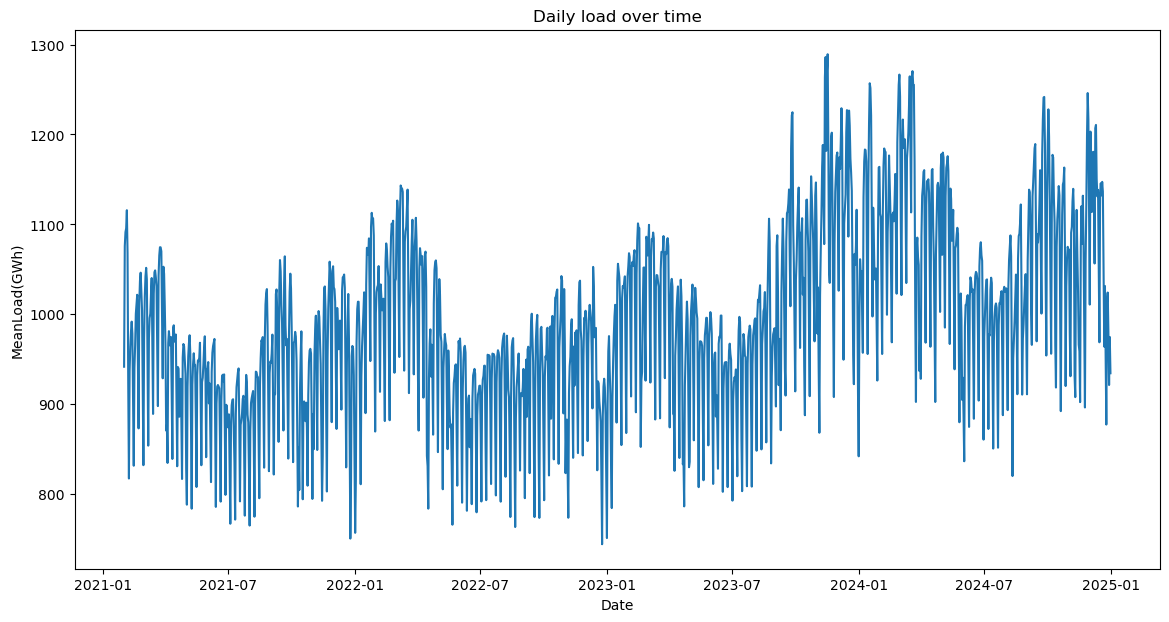

In [4]:
plt.figure(figsize=(14, 7))

plt.plot(df.index, df["load"])
plt.title('Daily load over time')
plt.xlabel('Date')
plt.ylabel('MeanLoad(GWh)')

plt.show()

In [5]:
###Insert plot year by year to have higher resolution

ADF Statistic: -3.09492448670836
p-value: 0.026931086434163035
✅ Data is stationary (p-value ≤ 0.05)


<Figure size 1200x500 with 0 Axes>

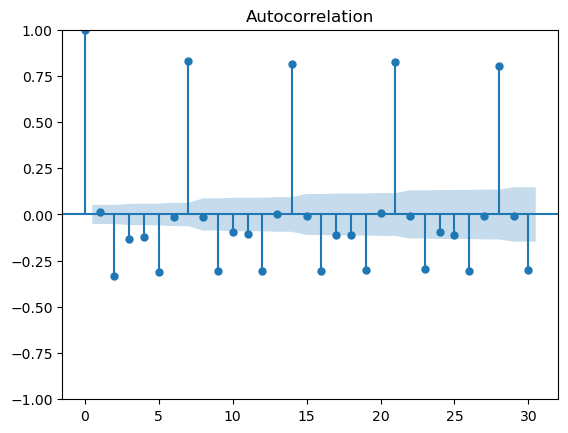

In [6]:
#Check data stationarity for ARIMA  

#Augmented Dickey-Fuller (ADF) Test
result = adfuller(df['load'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("✅ Data is stationary (p-value ≤ 0.05)")
else:
    print("❌ Data is non-stationary (p-value > 0.05)")

df['load_diff'] = df['load'] - df['load'].shift(1)

plt.figure(figsize=(12, 5))
plot_acf(df['load_diff'].dropna(), lags=30)
plt.title("Autocorrelation")
plt.show()

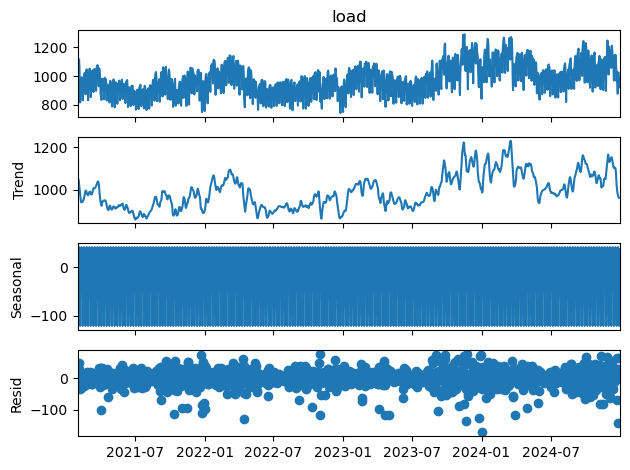

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['load'], period=7)
decomposition.plot()
plt.show()


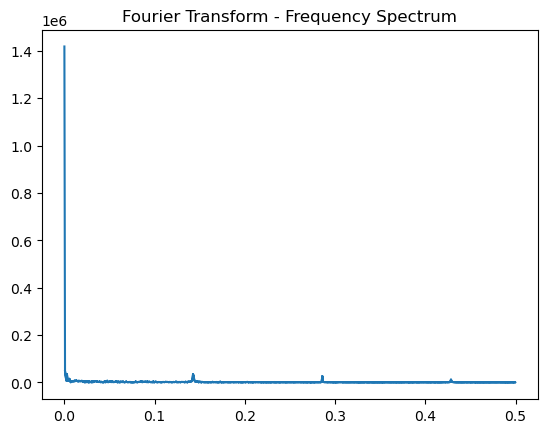

In [8]:
fft_vals = np.fft.fft(df['load'])
fft_freqs = np.fft.fftfreq(len(df))

plt.plot(np.abs(fft_freqs), np.abs(fft_vals))
plt.title("Fourier Transform - Frequency Spectrum")
plt.show()

In [9]:
# Resample to weekly, monthly, and yearly averages
df_daily = df.copy()
df_weekly = df.resample('W', on='date').mean()
df_monthly = df.resample('ME', on='date').mean()
df_yearly = df.resample('YE', on='date').mean()


def adf_check(series, title=''):
    result = adfuller(series.dropna())
    print(f'{title} ADF Statistic: {result[0]:.2f}')
    print(f'{title} p-value: {result[1]:.2f}')
    if result[1] <= 0.05:
        print(f"✅ {title} data is stationary (p ≤ 0.05)\n")
    else:
        print(f"❌ {title} data is NOT stationary (p > 0.05)\n")

# Run ADF on each resampled data
adf_check(df_daily['load'], 'Daily Data')
adf_check(df_weekly['load'], 'Weekly Data')
adf_check(df_monthly['load'], 'Monthly Data')
adf_check(df_yearly['load'], 'Yearly Data')


Daily Data ADF Statistic: -3.09
Daily Data p-value: 0.03
✅ Daily Data data is stationary (p ≤ 0.05)

Weekly Data ADF Statistic: -2.20
Weekly Data p-value: 0.21
❌ Weekly Data data is NOT stationary (p > 0.05)

Monthly Data ADF Statistic: -2.19
Monthly Data p-value: 0.21
❌ Monthly Data data is NOT stationary (p > 0.05)

Yearly Data ADF Statistic: 1.33
Yearly Data p-value: 1.00
❌ Yearly Data data is NOT stationary (p > 0.05)



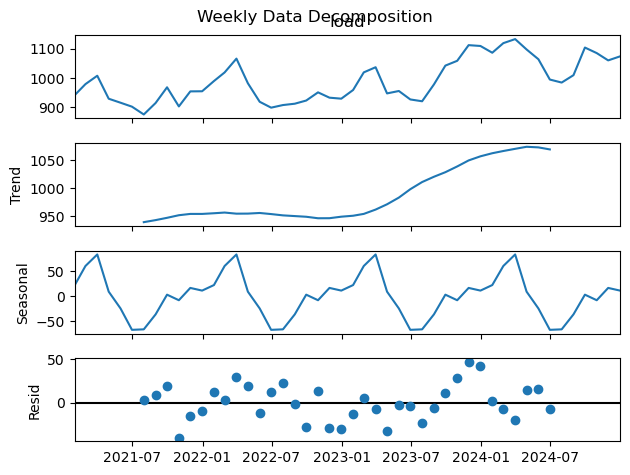

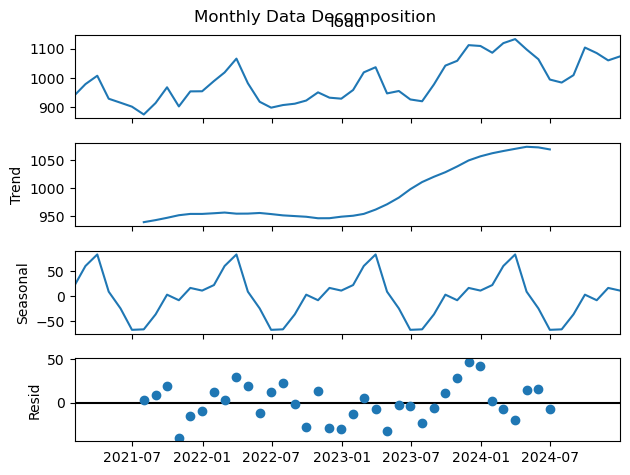

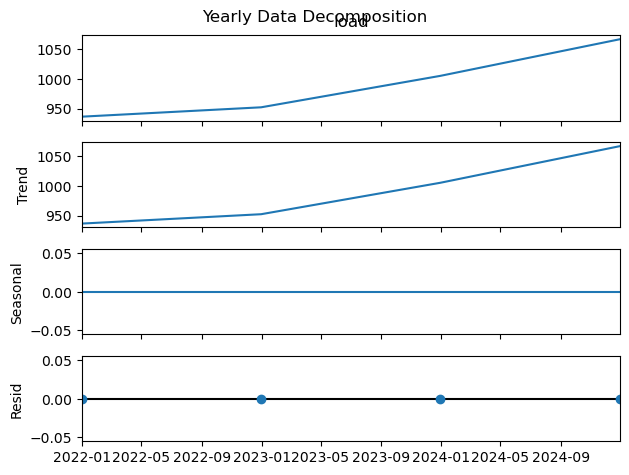

In [10]:
# Weekly decomposition
decomp_weekly = seasonal_decompose(df_monthly['load'], period=12)
decomp_weekly.plot()
plt.suptitle("Weekly Data Decomposition")
plt.show()

# Monthly decomposition
decomp_monthly = seasonal_decompose(df_monthly['load'], period=12)
decomp_monthly.plot()
plt.suptitle("Monthly Data Decomposition")
plt.show()

# Yearly decomposition (if you have enough data)
if len(df_yearly) > 2:
    decomp_yearly = seasonal_decompose(df_yearly['load'], period=1)
    decomp_yearly.plot()
    plt.suptitle("Yearly Data Decomposition")
    plt.show()


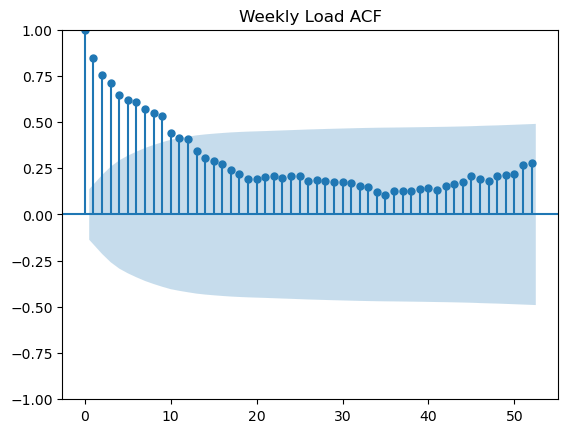

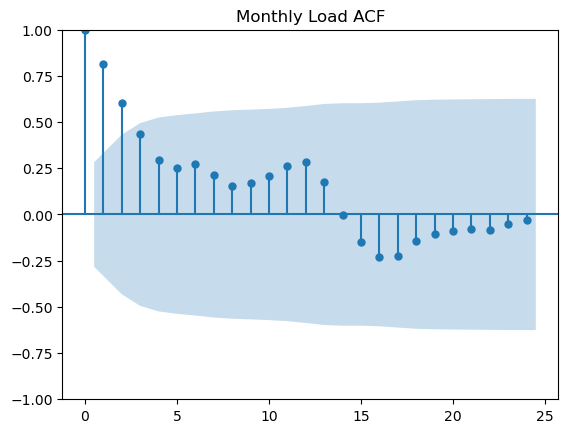

In [11]:
# # plt.figure(figsize=(12, 6))
plot_acf(df_weekly['load'].dropna(), lags=52)
plt.title("Weekly Load ACF")
plt.show()

plot_acf(df_monthly['load'].dropna(), lags=24)
plt.title("Monthly Load ACF")
plt.show()


<Figure size 1200x600 with 0 Axes>

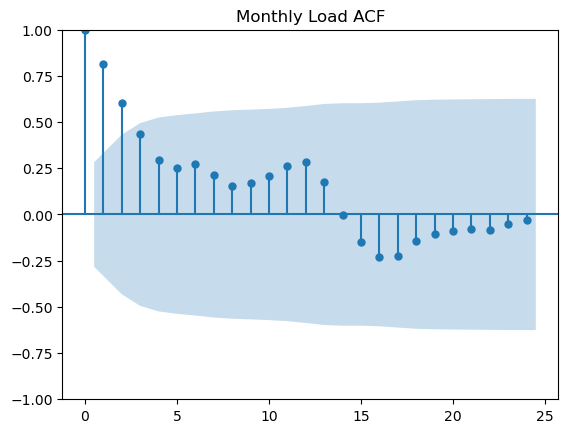

In [12]:
plt.figure(figsize=(12, 6))
plot_acf(df_monthly['load'].dropna(), lags=24)
plt.title("Monthly Load ACF")
plt.show()


### Main observations on the data analisys:
* Daily Data data is stationary (p ≤ 0.05) 
* Weekly Data data is NOT stationary (p > 0.05)     
* Monthly Data data is NOT stationary (p > 0.05)    
* Yearly Data data is NOT stationary (p > 0.05)  

* Monthly and weekly data are highly seasonal while yearly data is not seasonal at all.  

* ACF Weekly:

-- 10 lags significantly positive → Short-term autocorrelation (weekly cycles).

Stays positive (but weaker) until lag 52 → Suggests a year-long weekly pattern (52 weeks/year).

* ACF Monthly:

First 3 lags significant → Likely quarterly pattern.

Turns negative after lag 14 → Possible 12-month annual cycle with mean-reverting behavior.

The aproach for the models from this is that it should be used 

Daily data → ARIMA 

Weekly data → SARIMA (52 weeks) 

Monthly data → SARIMA (12 months) 

Yearly data → ARIMA or differencing for trend 

In [13]:
#Train test split
from sklearn.model_selection import TimeSeriesSplit

# Ensure 'date' is your index
df.set_index('date', inplace=True)

# Define the split point
split_date = '2024-01-01'

# Split train and test
train_df = df.loc[:split_date]
test_df = df.loc[split_date:]

print(f"Train set: {train_df.shape[0]} rows")
print(f"Test set: {test_df.shape[0]} rows")


Train set: 1066 rows
Test set: 366 rows


In [14]:
#pipeline(feature normalization)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

# Normalize features (only for XGBoost, ARIMA doesn't need it)
scaler = MinMaxScaler()

def preprocess_data(df, model_type):
    """
    Preprocess data differently depending on model type.
    ARIMA/SARIMA needs raw time series; XGBoost needs scaled features.
    """
    if model_type in ['xgboost']:
        df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])
    return df

# Function to evaluate model performance
def evaluate_model(true, pred):
    """
    Calculates RMSE, MAE, and MAPE to evaluate the models.
    """
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# General pipeline function for training & prediction
def run_model_pipeline(train_df, test_df, model_type='arima', order=(1,1,1), seasonal_order=(0,0,0,0)):
    """
    Runs ARIMA, SARIMA, or XGBoost models in a standardized pipeline.
    """
    # Preprocess data
    train_df = preprocess_data(train_df.copy(), model_type)
    test_df = preprocess_data(test_df.copy(), model_type)

    # Extract target
    y_train = train_df['load']
    y_test = test_df['load']
    
    # ARIMA Model
    if model_type == 'arima':
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(y_test))

    # SARIMA Model (for seasonal data)
    elif model_type == 'sarima':
        model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(y_test))

    # XGBoost Model
    elif model_type == 'xgboost':
        X_train = train_df.drop('load', axis=1)
        X_test = test_df.drop('load', axis=1)
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

    else:
        raise ValueError("Model type not supported. Use 'arima', 'sarima', or 'xgboost'.")

    # Evaluate the model
    metrics = evaluate_model(y_test, predictions)
    print(f"{model_type.upper()} Results:", metrics)
    return model, predictions


In [15]:
#ARIMA + SARIMA (model+eval)
#XGB (model+eval)

# Train ARIMA
arima_model, arima_preds = run_model_pipeline(train_df, test_df, model_type='arima', order=(2,1,2))

# Train SARIMA (assuming weekly seasonality, 7-day cycle)
sarima_model, sarima_preds = run_model_pipeline(train_df, test_df, model_type='sarima',
                                                order=(1,1,1), seasonal_order=(1,1,1,7))

# Train XGBoost
xgb_model, xgb_preds = run_model_pipeline(train_df, test_df, model_type='xgboost')

c:\Users\Lucas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Lucas\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

ARIMA Results: {'RMSE': 94.38336767169442, 'MAE': 77.81519448333361, 'MAPE': 7.369823027398923}


c:\Users\Lucas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lucas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA Results: {'RMSE': 319.8879642902907, 'MAE': 304.22776723817014, 'MAPE': 28.32534989595688}


C:\Users\Lucas\AppData\Local\Temp\ipykernel_24312\2656910954.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.         0.16666667 ... 0.83333333 1.         0.        ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])
C:\Users\Lucas\AppData\Local\Temp\ipykernel_24312\2656910954.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.09090909 0.09090909 ... 1.         1.         0.        ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])
C:\Users\Lucas\AppData\Local\Temp\ipykernel_24312\2656910954.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.       

XGBOOST Results: {'RMSE': 36.30381567188553, 'MAE': 31.432412748452442, 'MAPE': 3.021306075731258}


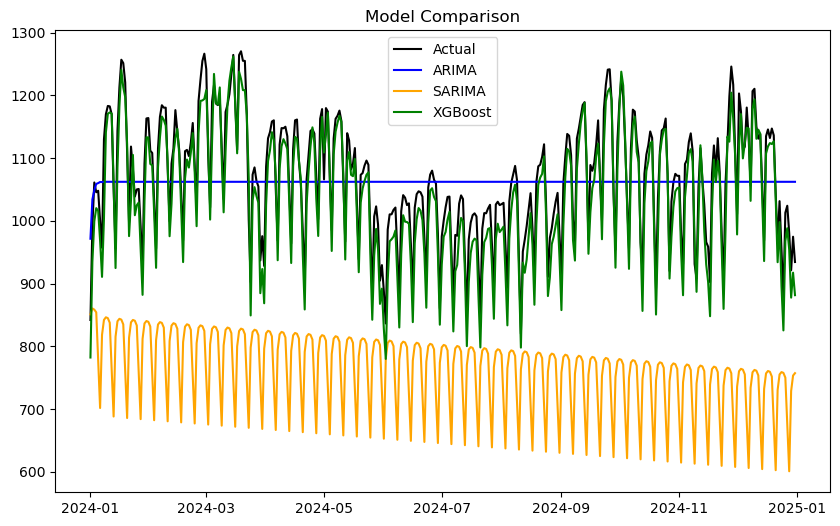

In [16]:
#Plot results vs actual values for both cases

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(test_df.index, test_df['load'], label='Actual', color='black')
plt.plot(test_df.index, arima_preds, label='ARIMA', color='blue')
plt.plot(test_df.index, sarima_preds, label='SARIMA', color='orange')
plt.plot(test_df.index, xgb_preds, label='XGBoost', color='green')

plt.legend()
plt.title("Model Comparison")
plt.show()


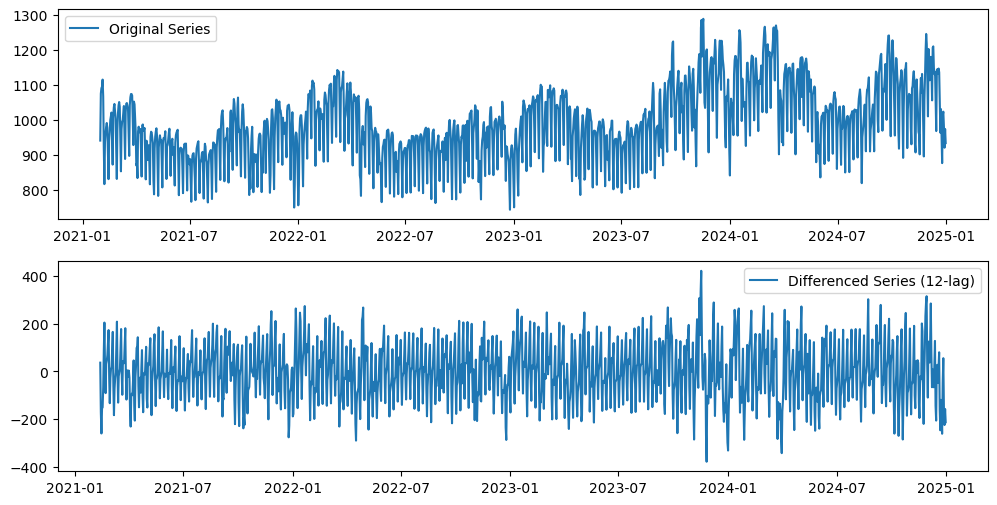

In [17]:
import matplotlib.pyplot as plt

df['load_diff1'] = df['load'].diff()  # First difference
df['load_diff12'] = df['load'].diff(12)  # Seasonal difference (monthly)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(df['load'], label='Original Series')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df['load_diff12'], label='Differenced Series (12-lag)')
plt.legend()
plt.show()


In [23]:
pip install --upgrade pip setuptools wheel

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
Using cached setuptools-78.1.0-py3-none-any.whl (1.3 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.43.0
    Uninstalling wheel-0.43.0:
      Successfully uninstalled wheel-0.43.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.5.1
    Uninstalling setuptools-69.5.1:
      Successfully uninstalled setuptools-69.5.1
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.5.1 requires ipython!=8.17.1,<9.0.0,>=8.13.0; python_version > "3.8", but you have ipython 8.12.3 which is incompatible.


In [24]:
pip install pdarima

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pdarima (from versions: none)
ERROR: No matching distribution found for pdarima


In [ ]:
pip install 'C:\Users\Lucas\Documents\Projects\Power-Usage-Prediction\pmdarima-2.0.4-cp312-cp312-win_amd64.whl'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'C:\\Users\\Lucas\\Documents\\Projects\\Power': Expected end or semicolon (after name and no valid version specifier)
    C:\Users\Lucas\Documents\Projects\Power
     ^
Hint: It looks like a path. File 'C:\Users\Lucas\Documents\Projects\Power' does not exist.


In [21]:
from pmdarima import auto_arima

auto_arima(df['load'], seasonal=False, trace=True, stepwise=True)
# For SARIMA (seasonal=True, m=7 for weekly, m=12 for monthly)
auto_arima(df['load'], seasonal=True, m=7, trace=True, stepwise=True)


ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
#Hyper param tunning (optional)